In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score
import numpy as np
import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))
    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))

    if ax is None:
        ax = plt.gca()
        
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    def __init__(self, accuracy, hidden_layer_sizes, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.accuracy = accuracy
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_layers = len(hidden_layer_sizes) + 1
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x):
        W = list()
        b = list()
        h = list(self.hidden_layer_sizes)

        h.insert(0, n_x)
        h.append(1)
        hidden_layers = tuple(h)
        
        for i in range(1, self.n_layers+1):
            W.append(np.random.randn(hidden_layers[i], hidden_layers[i-1]) * 0.01)
            b.append(np.zeros((hidden_layers[i], 1)))

        self.parameters = {"W" : W, "b" : b}
                    
    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]
        A = []
        Z = []
        
        for i in range(0, self.n_layers):
            if i == 0:
                Z.append(np.dot(W[i], X) + b[i])
            else:
                Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
                       
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * (self.n_layers)
        dA = [None] * (self.n_layers)
        dZ = [None] * (self.n_layers)
        db = [None] * (self.n_layers)
        
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        
        for i in range(self.n_layers-1, 0, -1):
            dA[i-1] = np.dot(W[i].T, dZ[i])
            dZ[i-1] = np.multiply(dA[i-1], np.multiply(A[i-1], 1 - A[i-1]))
            if i-1 == 0:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], X.T)
            else:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True)        
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads
    
    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]

        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.n_layers):
            W[i] = W[i] - self.learning_rate * dW[i]
            b[i] = b[i] - self.learning_rate * db[i]

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        self.n_iter = 0
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x)

        for i in range(self.num_iter):
            self.n_iter = i
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            costs.append(cost)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)
            
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))
                
            if i > 1 and abs(cost-costs[-2]) < self.accuracy:
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)

In [6]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


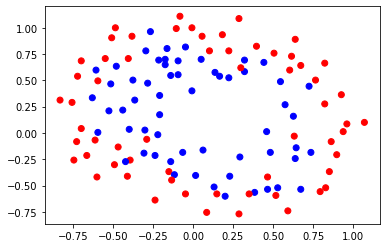

In [7]:
plot_data(X, Y)

In [8]:
cls = NeuralNet(
    accuracy=1e-12,
    hidden_layer_sizes=(20,15), 
    normalize = True, 
    learning_rate = 0.52, 
    num_iter = 14001)

0-th iteration: 0.6937540515777744
1000-th iteration: 0.69300340822496
2000-th iteration: 0.6930032275082856
3000-th iteration: 0.6930029865977814
4000-th iteration: 0.6930026159892181
5000-th iteration: 0.6930019708657253
6000-th iteration: 0.6930006954783263
7000-th iteration: 0.6929977368102638
8000-th iteration: 0.692989037238604
9000-th iteration: 0.6929503546549968
10000-th iteration: 0.6925362387382307
11000-th iteration: 0.6874802478091414
12000-th iteration: 0.5972647427515569
13000-th iteration: 0.47607771945381805
14000-th iteration: 0.31585497059496453


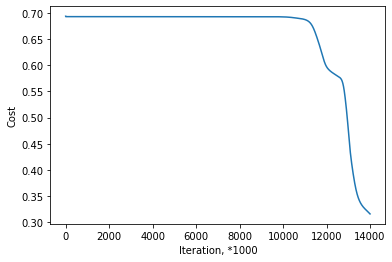

In [9]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [10]:
print(cls.parameters)

{'W': [array([[ 1.63828181,  0.3418867 ],
       [-0.47281659, -0.28894345],
       [-0.46930352, -0.32019877],
       [ 0.38585122, -0.29199629],
       [-0.41112943, -0.31925876],
       [-1.19722042,  0.82153676],
       [-0.38736807, -0.32749168],
       [-0.50789082, -0.30472879],
       [-0.29230894, -0.29275304],
       [ 0.69476173, -1.28935008],
       [-0.18291761,  2.13307555],
       [ 0.51076564,  0.26441677],
       [-0.40775586, -0.32461259],
       [-0.46957861, -0.32245294],
       [ 0.58791374,  1.26009876],
       [-0.36915925, -0.30171933],
       [-0.46547048, -0.28941499],
       [-2.33345886, -0.86190121],
       [-0.93608332, -0.71918722],
       [-0.4610997 , -0.29883227]]), array([[-5.85595510e-01,  3.60304149e-01,  4.72137151e-01,
         2.48406160e-01,  4.37043560e-01, -1.25785531e+00,
         4.22600690e-01,  2.85365353e-01,  3.46395227e-01,
        -1.35208699e+00,  1.22118699e+00, -9.50396741e-02,
         4.29205196e-01,  4.93668527e-01, -1.28513771e+

In [11]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.61826464, 0.38173536],
       [0.91095794, 0.08904206],
       [0.23372529, 0.76627471],
       [0.0987039 , 0.9012961 ],
       [0.0463449 , 0.9536551 ],
       [0.91387102, 0.08612898],
       [0.03210104, 0.96789896],
       [0.21561397, 0.78438603],
       [0.81269765, 0.18730235],
       [0.9529969 , 0.0470031 ],
       [0.98945033, 0.01054967],
       [0.24598907, 0.75401093],
       [0.30343801, 0.69656199],
       [0.02460986, 0.97539014],
       [0.84749546, 0.15250454],
       [0.10736071, 0.89263929],
       [0.63081744, 0.36918256],
       [0.75155878, 0.24844122],
       [0.83085768, 0.16914232],
       [0.06387   , 0.93613   ],
       [0.99474755, 0.00525245],
       [0.88109671, 0.11890329],
       [0.84305948, 0.15694052],
       [0.01117426, 0.98882574],
       [0.25674223, 0.74325777],
       [0.89857447, 0.10142553],
       [0.1887193 , 0.8112807 ],
       [0.3402707 , 0.6597293 ],
       [0.45126853, 0.54873147],
       [0.92893397, 0.07106603],
       [0.

In [12]:
Y_hat = cls.predict(X)
Y_hat

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0])

In [13]:
accuracy_score(Y, Y_hat)

0.847457627118644

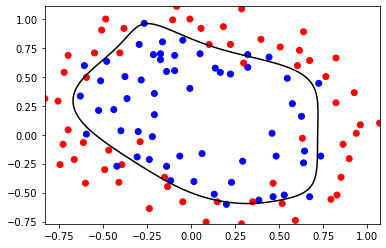

In [14]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [15]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (5,10,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [16]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(5, 10), learning_rate_init=0.01,
              max_iter=10000, solver='sgd')

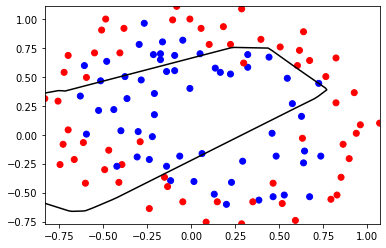

In [17]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [18]:
accuracy_score(Y, clf.predict(X))

0.635593220338983

In [19]:
clf.n_iter_

77